Import modules

In [3]:
import numpy as np
from tensorflow import keras as ks
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import backend as K
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from skimage.io import imread, imsave
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import figure
from matplotlib.ticker import MaxNLocator
from styleTransfer import generateImageFromGramMatrix, generateImageFromStyle
import os
import asyncio

%matplotlib inline
%load_ext autoreload
%autoreload 2
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
tf.__version__
# tf.compat.v1.disable_eager_execution()
# matplotlib.rc('axes', labelsize=18) 
# matplotlib.rc('figure', titlesize=18) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'2.1.0'

some constants

In [4]:
TRAIN = 'train_euler'
classes = ['300.9', '600.3', '600.9']
classes_all = ['300.3', '300.9', '600.3', '600.9']
CLASS_LABELS = ['M1', 'M2', 'M3']
TRAINING_SIZE_SMALL = 160
imgDir = 'train_euler'
CLASSES_AL = ['al']
AL_DIR = 'al'
TRAINING_SIZE = 1800
BATCH_SIZE = 20
IMAGE_SIZE = (448, 448)
N_PC = 5


###### Create sliding window of the 4 original dataset

two helper functions

In [5]:
"""
read all images from a folder
"""

def load_images_from_folder(folder):
	images = []
	for filename in os.listdir(folder):
		img = cv2.imread(os.path.join(folder,filename))
		if img is not None:
			images.append(img)
	return images


"""
write all possible sliding windows to disk
"""

def sliding_window(image, stepSize, windowSize, classPath):
	# slide a window across the image
	counterImages = 0
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			currWindow = image[y: y + windowSize[1], x: x + windowSize[0]]
			if currWindow.shape != IMAGE_SIZE + (3,):
				continue
			currImagePath = os.path.join(classPath, str(counterImages)) + '.png'
			cv2.imwrite(currImagePath, currWindow)
			counterImages += 1


start the sliding window generation process

In [8]:

images = load_images_from_folder('orig_euler')

counter = 0
for image in images:
	classPath = os.path.join(TRAIN, classes_all[counter])
	if not os.path.exists(classPath):
		os.mkdir(classPath)
	sliding_window(image, 3, IMAGE_SIZE, classPath)
	counter+=1



Apply sliding window on al

In [65]:
images = load_images_from_folder('orig_Al')
classPath = os.path.join(TRAIN, 'al')
if not os.path.exists(classPath):
    os.mkdir(classPath)
sliding_window(images[0], 3, IMAGE_SIZE, classPath)

Read generated sliding window and do data augmentation 
by randomly seleft and random flips

Found 62643 images belonging to 3 classes.
{'300.9': 0, '600.3': 1, '600.9': 2}


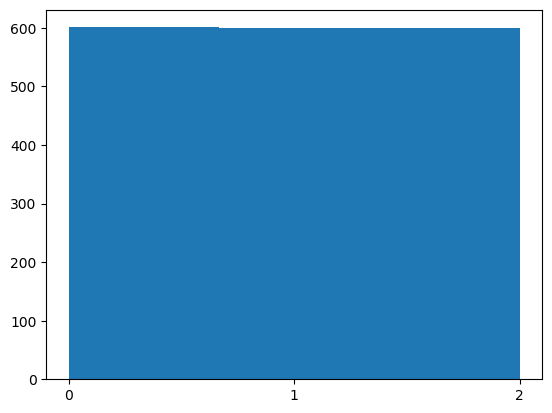

(array([601, 599, 600], dtype=int64),
 array([0.       , 0.6666667, 1.3333334, 2.       ], dtype=float32))

In [6]:
aug = ImageDataGenerator(
		# horizontal_flip=True,
		# vertical_flip=True,
		fill_mode="nearest", rescale=1/255.0)


augmentation = aug.flow_from_directory(imgDir, classes=classes, batch_size = TRAINING_SIZE, target_size=IMAGE_SIZE, shuffle=True, seed=20, class_mode="sparse")
print(augmentation.class_indices)
for x, y in augmentation:
	data = x
	labels = y
	break
# data = preprocess_input(data)
fig = plt.figure()
fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.hist(labels, len(classes))
plt.show()
np.histogram(labels, bins=3)


In [23]:
def deprocess_image(x):
    # if K.image_data_format() == "channels_first":
    #     x = x.reshape((3, img_width, img_height))
    #     x = x.transpose((1, 2, 0))
    # else:
    #     x = x.reshape((img_width, img_height, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # BGR -> RGB
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

Draw figure of original pics

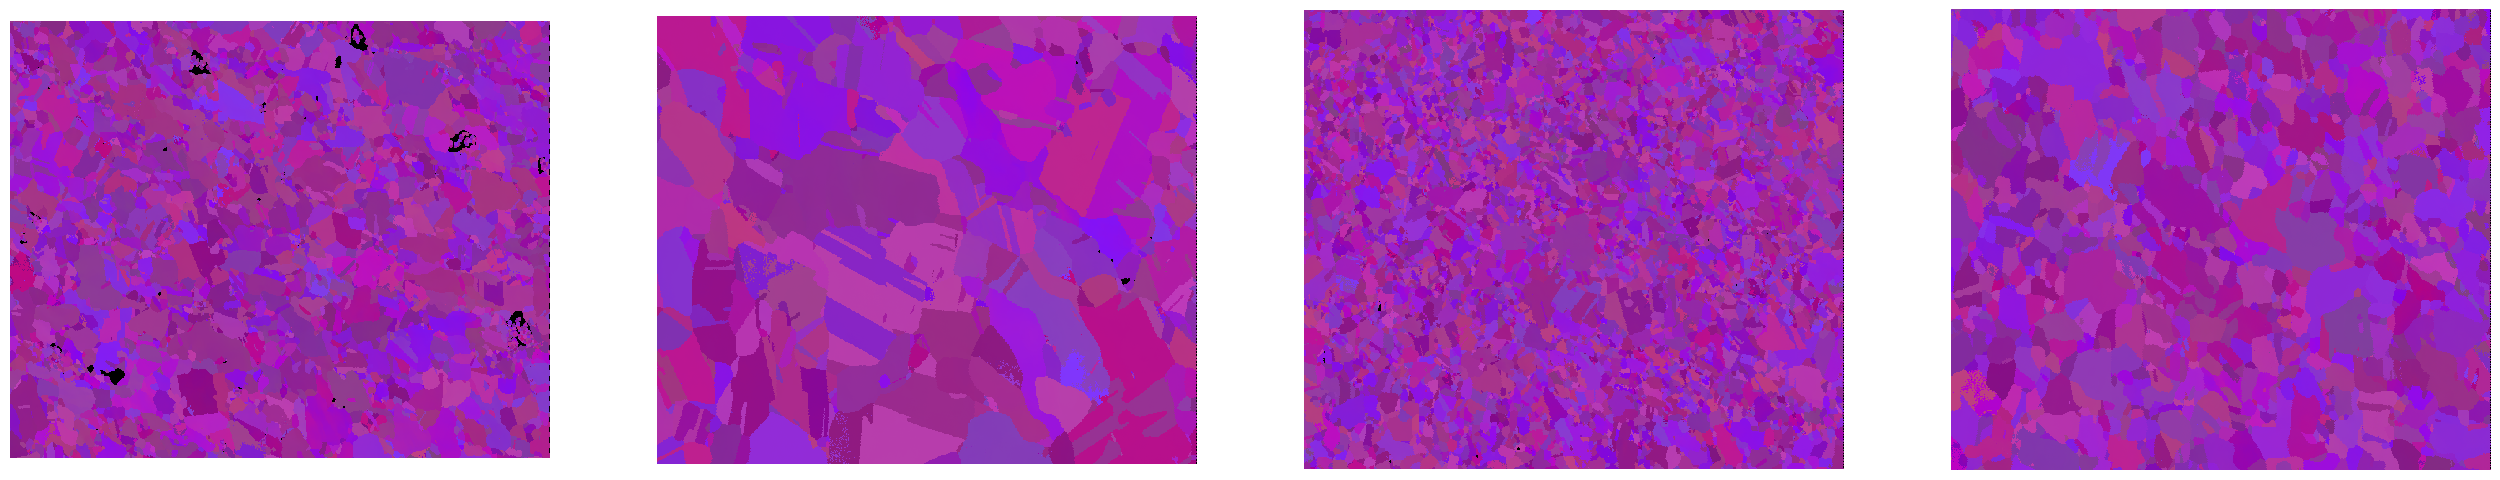

In [10]:
fig = plt.figure(figsize=(32, 16))
counter = 1
for subdir, dirs, files in os.walk('orig_euler'):
	for file in files:
		origImg = cv2.imread(os.path.join(subdir, file))
		fig.add_subplot(1, 4, counter)
		plt.axis('off')
		plt.imshow(origImg)
		counter += 1
plt.savefig('original.png', transparent=True, dpi=300)
plt.show()


Figure X: The four original dataset. 

Draw figure for augmented pics

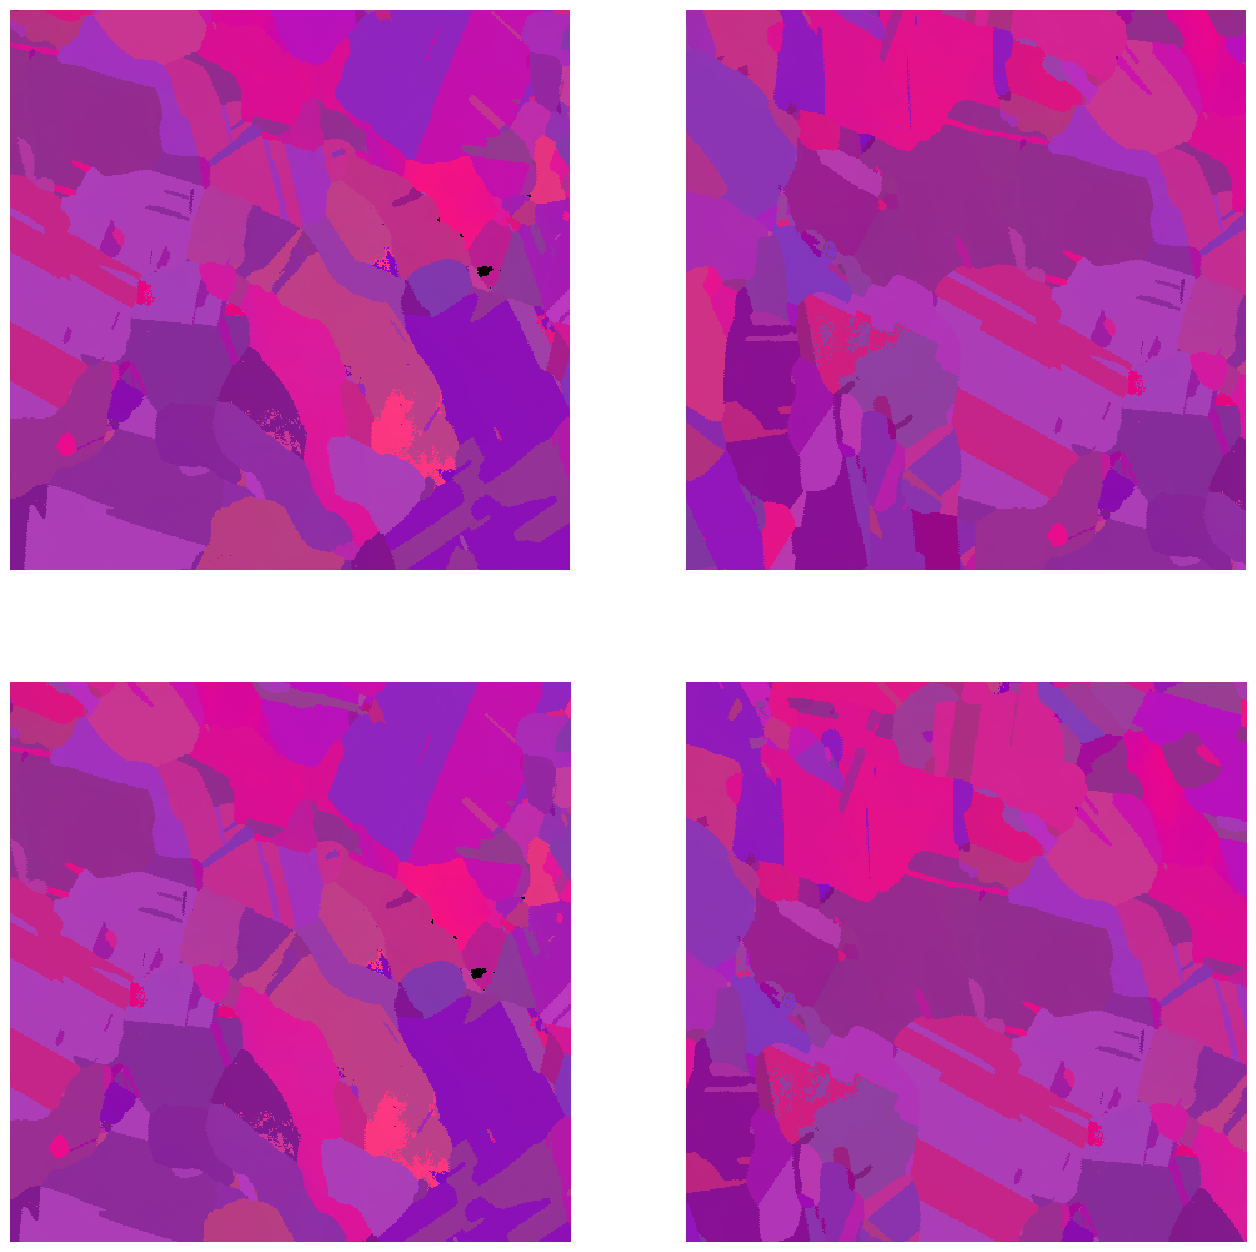

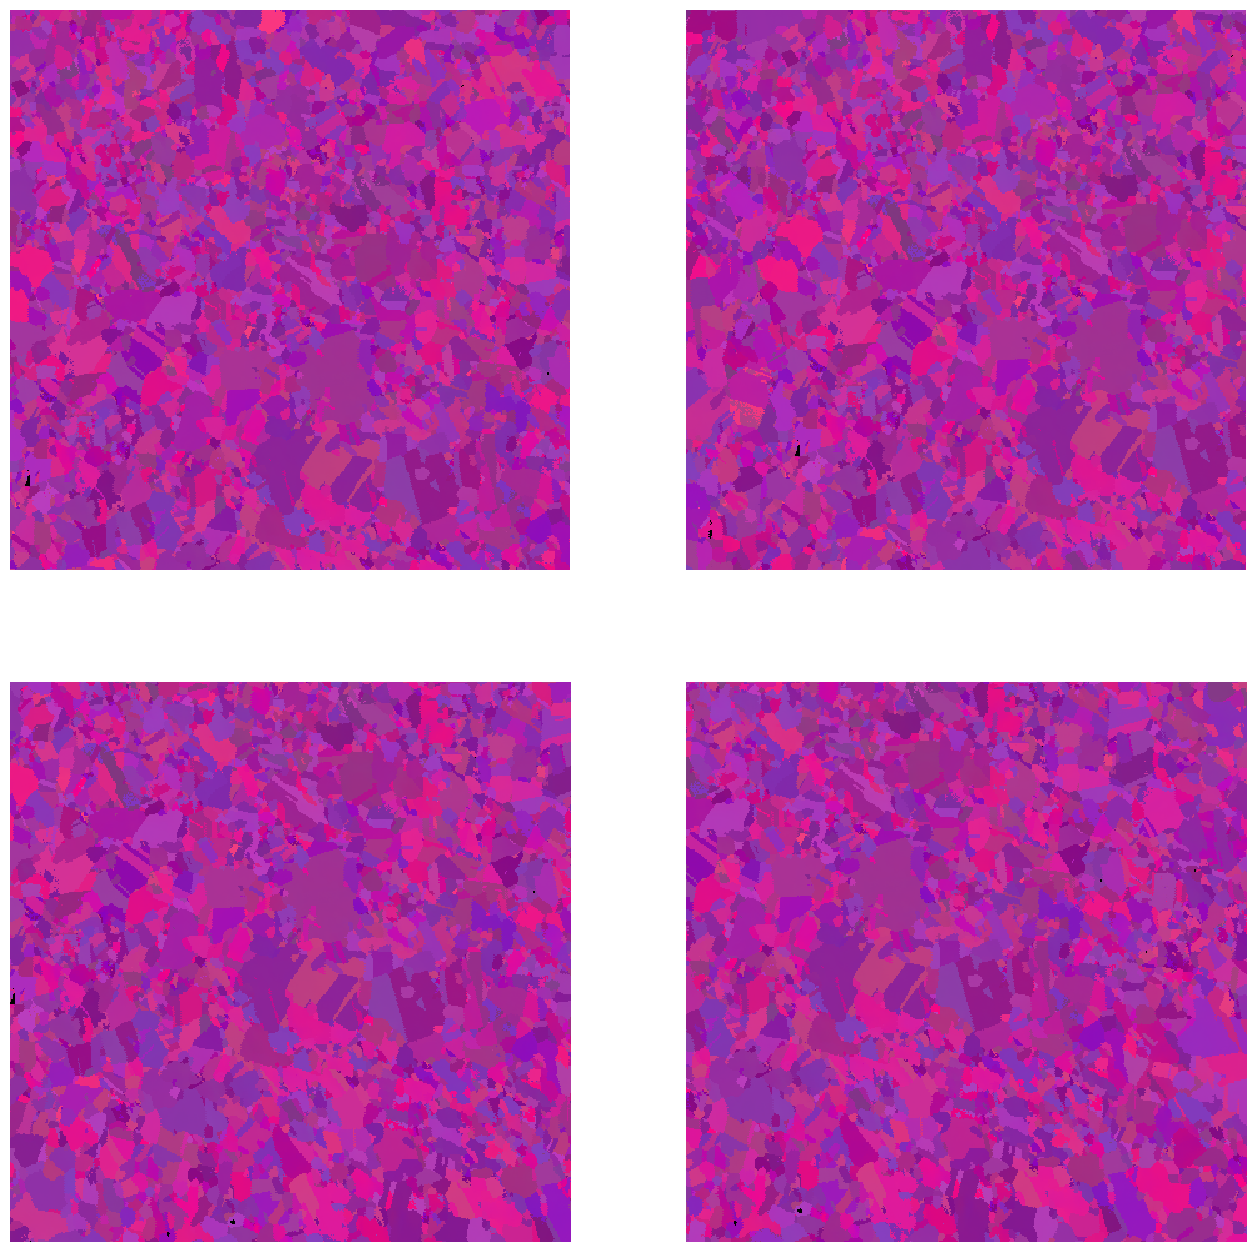

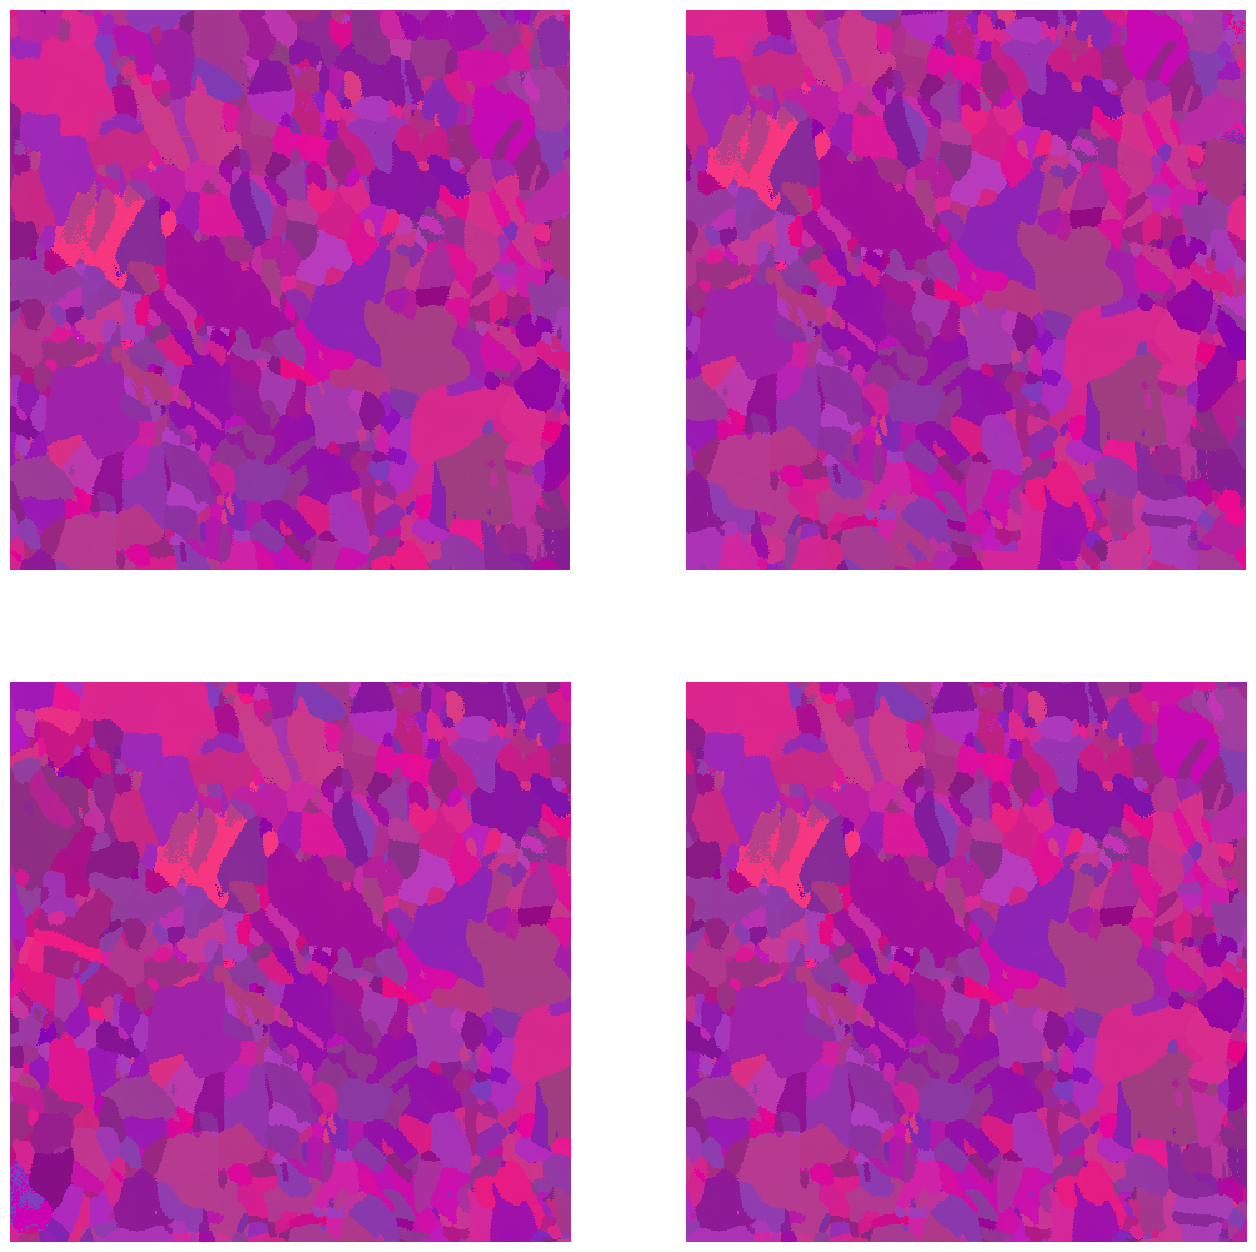

In [12]:
drawing = data
fig = plt.figure(figsize=(16, 16))
counter = 1
idx = np.random.choice(np.where(labels == 0)[0], 4)
for j in idx:
	fig.add_subplot(2, 2, counter)
	plt.axis('off')
	plt.imshow(drawing[j])
	counter += 1


plt.savefig('sample_300.9.png', transparent=True, dpi=300)
plt.show()


fig = plt.figure(figsize=(16, 16))
counter = 1
idx = np.random.choice(np.where(labels == 1)[0], 4)
for j in idx:
	fig.add_subplot(2, 2, counter)
	plt.axis('off')
	plt.imshow(drawing[j])
	counter += 1
plt.savefig('sample_600.3.png', transparent=True, dpi=300)
plt.show()

fig = plt.figure(figsize=(16, 16))
counter = 1
idx = np.random.choice(np.where(labels == 2)[0], 4)
for j in idx:
	fig.add_subplot(2, 2, counter)
	plt.axis('off')
	plt.imshow(drawing[j])
	counter += 1
plt.savefig('sample_600.9.png', transparent=True, dpi=300)
plt.show()


Figure X: Some sample of augmented dataset

extract features

This function calculate the gram matrix

In [9]:
def gram_matrix_batch(x):
    features = K.reshape(x, shape=(K.shape(x)[0], x.shape[1] * x.shape[2], x.shape[3]))
    features_T = K.permute_dimensions(features, (0, 2, 1))
    gram = K.batch_dot(features_T, features)
    gram = K.batch_flatten(gram)
    return gram

Construct the VGG 16 network

In [25]:


K.clear_session()
import gc
gc.collect()
# input_tensor = ks.Input(data.shape[1:])

# network = VGG19(weights=None, include_top=False, input_tensor=input_tensor, pooling='avg')
network = ks.models.load_model('vgg19_bn.h5')
input_tensor = network.input
#network = ks.Model(input_tensor, vgg16(input_tensor))
network.summary()
#features = network.predict(data)

Model: "vgg19_bn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 448, 448, 64)      1792      
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 448, 448, 64)      256       
_________________________________________________________________
block1_act1 (Activation)     (None, 448, 448, 64)      0         
_________________________________________________________________
block1_dropout1 (Dropout)    (None, 448, 448, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 448, 448, 64)      36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 448, 448, 64)      256

Get functors for the gram matrix for each layers for a whole batch

In [26]:
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
layers = dict([(layer.name, layer.output) for layer in network.layers])
all_grams = []
for layer_name in feature_layers:
    style_features = layers[layer_name]
    gram = gram_matrix_batch(style_features)
    all_grams.append(gram)

functor = K.function(input_tensor, all_grams)


Get the gram matrix value, this function split the entire input into small batches to avoid OOM

In [29]:
def get_gram_batch(data):
    n_split = TRAINING_SIZE / BATCH_SIZE
    spliltted = np.array_split(data, n_split)
    results = []
    for batch in spliltted:
        batch_result = functor(batch)
        results.append(np.concatenate(batch_result, axis=1))
    features = np.concatenate(results, axis=0)
    return features
    

In [28]:
features = get_gram_batch(data)
features.shape

(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 448, 3)
(20, 448, 

(1800, 610304)

Feature extraction method

In [ ]:
features_old = network.predict(data)
features_old = features_old.reshape((features_old.shape[0],-1))

Helper function to evaluate different dimensions of PCA with different type of SVM

In [30]:
async def evaluateSVM_PCA(dimension, data, labels, SVM_type):
	pca = PCA(n_components=dimension)
	pcaFeatures = pca.fit_transform(data)
	X_train, X_test, y_train, y_test = train_test_split(pcaFeatures, labels, shuffle=False, test_size = 0.2)
	if SVM_type == 'linear':
		model = svm.LinearSVC(max_iter=10000)
	elif SVM_type == 'poly':
		model = svm.SVC(kernel='poly', degree=3, gamma='auto')
	elif SVM_type == 'rbf':
		model = svm.SVC(kernel='rbf', gamma='auto')
		
	model.fit(X_train, y_train)
	score = model.score(X_test, y_test)
	
	return score


Evaluate and plot accuracies of different models

In [31]:
"""
New Method: Gram matrix
"""

explainations = []

for i in range(2, 11):
    pca = PCA(n_components=i)
    pca.fit(features)
    explainations.append(np.sum(pca.explained_variance_ratio_))

accuracies = dict()
accuracies_old = dict()
accuracies['LinearSVM'] = await asyncio.gather(*[evaluateSVM_PCA(i, features, labels, 'linear') for i in range(2, 11)])

# """
# Old method: Feature Extraction
# """

# accuracies_old['LinearSVM'] = await asyncio.gather(*[evaluateSVM_PCA(i, features_old, labels, 'linear') for i in range(2, 11)])
# accuracies_old['3Poly'] = await asyncio.gather(*[evaluateSVM_PCA(i, features_old, labels, 'poly') for i in range(2, 11)])
# accuracies_old['RBF'] = await asyncio.gather(*[evaluateSVM_PCA(i, features_old, labels, 'rbf') for i in range(2, 11)])

C:\Users\AngelofDeath\.conda\envs\thesis\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\AngelofDeath\.conda\envs\thesis\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


plot accuracies with different SVM and PCA components

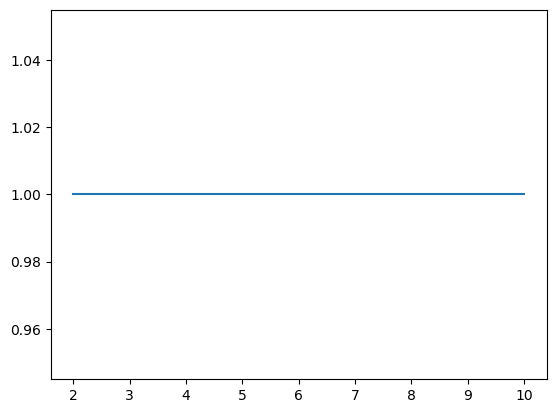

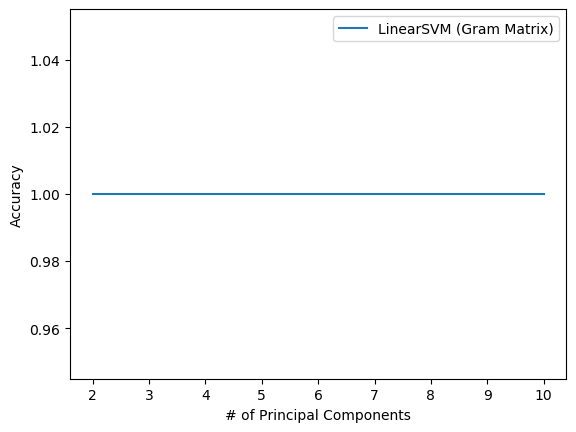

In [33]:
fig = plt.figure()
fig.add_subplot()
x = range(2,11)
plt.plot(x, accuracies['LinearSVM'])
# plt.plot(x, accuracies_old['LinearSVM'])
# plt.plot(x, accuracies_old['3Poly'])
# plt.plot(x, accuracies_old['RBF'])

fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(['LinearSVM (Gram Matrix)', 'LinearSVM (Feature Extraction)', '3Degree (Feature Extraction)', 'RBF (Feature Extraction)'])

plt.xlabel('# of Principal Components')
plt.ylabel('Accuracy')

plt.savefig('acc_vs_npc.png', dpi=300)
plt.show()

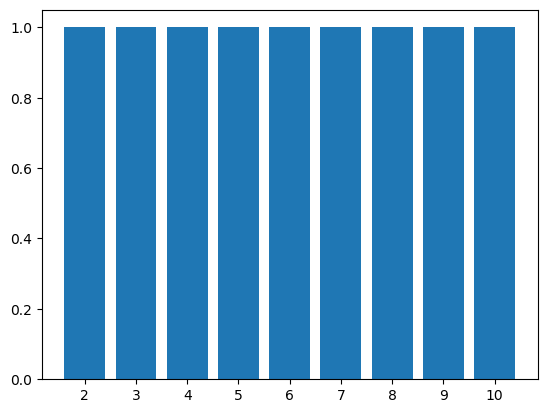

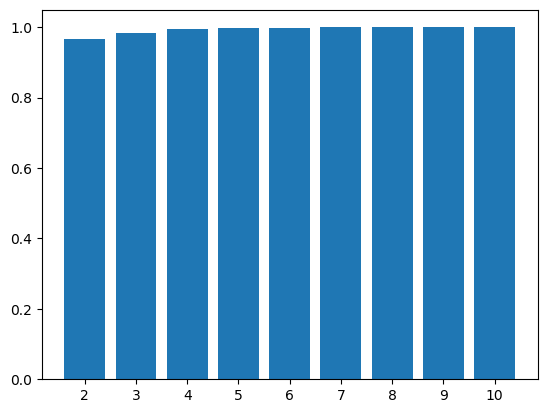

In [34]:
fig = plt.figure()
fig.add_subplot()
x = range(2,11)
plt.bar(x, accuracies['LinearSVM'])
plt.xticks(x)
fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.legend(['LinearSVM'])

# plt.xlabel('Number of Principal Components')
 
# plt.ylabel('classification Accuracy')

plt.savefig('acc_vs_npc.png', dpi=300)
plt.show()


fig = plt.figure()
fig.add_subplot()
x = range(2,11)
plt.bar(x, explainations)
plt.xticks(x)
fig.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
#plt.legend(['LinearSVM'])

# plt.xlabel('Number of Principal Components')
 
# plt.ylabel('classification Accuracy')

plt.savefig('exp_vs_npc.png', dpi=300)
plt.show()

Figure X: Accuracy vs number of principal comnponents. 
Tested on three SVM models. 
A normal SVM model
with no kernel. A SVM model with 3 degree polynomial kernel 
and a SVM with radial basis kernel

Train the classifer with dimension=8 and evaluate the result

In [35]:
pca = PCA(n_components=N_PC)
X_train_, X_test_, y_train_, y_test_ = train_test_split(features, labels, shuffle=False, test_size=0.2)
X_train = pca.fit_transform(X_train_)

X_test = pca.transform(X_test_)
pcaFeatures = pca.transform(features)
X_train, X_test, y_train, y_test = train_test_split(pcaFeatures, labels, shuffle=False, test_size=0.2)


draw the confusion matrix

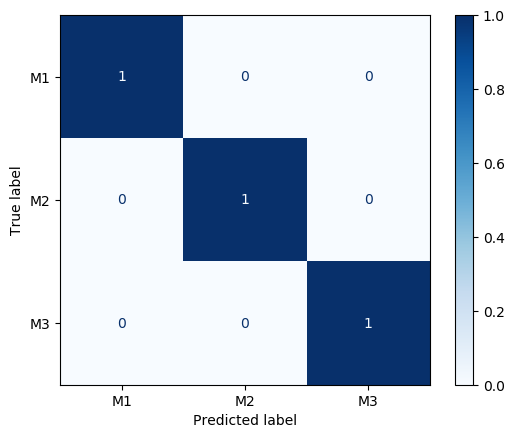

In [36]:
model = svm.LinearSVC(max_iter=200000)
model.fit(X_train, y_train)
disp = plot_confusion_matrix(model, X_test, y_test, display_labels=CLASS_LABELS, normalize='true', cmap=plt.cm.Blues)
#disp.ax_.set_title('Confusion Matrix', fontsize=18)
plt.savefig('confmat.png', dpi=300)
plt.show()

Figure X: Confusion matrix of the optimal model. 

Draw the scatter plot (PCA reduced domain) visualize feature using first two components of PCA

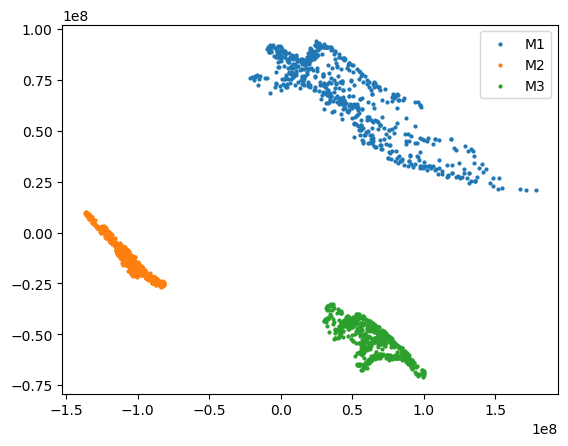

In [37]:
fig = plt.figure()
# fig.add_subplot()

counter = 1
for i in range(3):
		idx = np.where(labels == i)
		plt.scatter(pcaFeatures[idx[0], 0], pcaFeatures[idx[0], 1], s=4)

plt.legend(CLASS_LABELS)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')

plt.savefig('pca.png', dpi=300)
plt.show()


Figure X: Plot of first two princial components of the dataset 

Draw the first 2 PCs in the reduced domain. with the validation data darkened. 

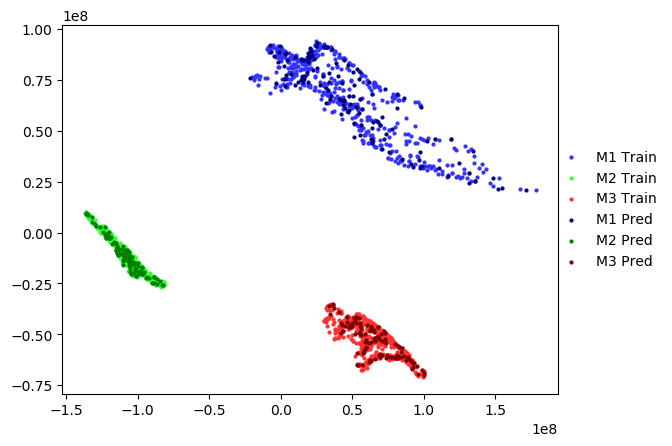

In [38]:
y_pred = model.predict(X_test)
COLORS = [(0.2, 0.2, 1), (0.2, 1, 0.2), (1, 0.2, 0.2), (0, 0, 0.5), (0, 0.5, 0), (0.5, 0, 0)]
counter = 1
fig, ax = plt.subplots()

for i in range(3):
		idx = np.where(y_train == i)
		ax.scatter(X_train[idx[0], 0], X_train[idx[0], 1], s=4, c=[COLORS[i]])

for i in range(3):
		idx = np.where(y_pred == i)
		ax.scatter(X_test[idx[0], 0], X_test[idx[0], 1], s=4, c=[COLORS[i+3]])
legends = ['M1 Train', 'M2 Train', 'M3 Train', 'M1 Pred', 'M2 Pred', 'M3 Pred']
lgd = ax.legend(legends, bbox_to_anchor=(1.21, 0.5), loc='center right', borderaxespad=0, frameon=False)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')

plt.savefig('pca_validation_set.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.clf()

Figure X: Plot of first two princial components of the dataset (validation dataset)

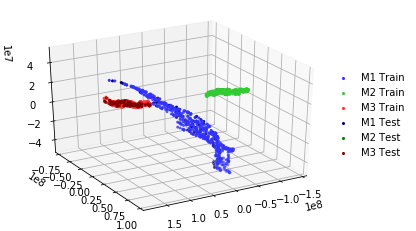

In [39]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=60)
y_pred = model.predict(X_test)
COLORS = [(0.2, 0.2, 1), (0.2, 0.8, 0.2), (1, 0.2, 0.2), (0, 0, 0.5), (0, 0.5, 0), (0.5, 0, 0)]

counter = 1
for i in range(3):
		idx = np.where(y_train == i)
		ax.scatter(X_train[idx[0], 0], X_train[idx[0], 1], X_train[idx[0], 2], s=4, c=[COLORS[i]])

for i in range(3):
		idx = np.where(y_test == i)
		ax.scatter(X_test[idx[0], 0], X_test[idx[0], 1], X_test[idx[0], 2], s=4, c=[COLORS[i+3]])
legends = ['M1 Train', 'M2 Train', 'M3 Train', 'M1 Test', 'M2 Test', 'M3 Test']
lgd = ax.legend(legends, bbox_to_anchor=(1.20, 0.5), loc='center right', borderaxespad=0, frameon=False)
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')
plt.savefig('pca_validation_set.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

Put the entire 300.3 in the plot, also add the centroid

In [40]:
def drawThingsOnReducedDomain(pcaFeatures, labels, things, legends, fileName, colors, sizes, markers, alphas):
    fig, ax = plt.subplots()
    counter = 1
    for i in range(3):
        idx = np.where(labels == i)
        ax.scatter(pcaFeatures[idx[0], 0], pcaFeatures[idx[0], 1], s=4, c=[COLORS[i]])
    
    for i in range(len(things)):
        ax.scatter(things[i][:, 0], things[i][:, 1], s=sizes[i], marker=markers[i], c=colors[i], alpha=alphas[i])
        counter += 1
    
    lgd = ax.legend([*CLASS_LABELS, *legends], bbox_to_anchor=(1.25, 0.5), loc='center right', borderaxespad=0, frameon=False)
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')

    plt.savefig(fileName, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [41]:
def drawThingsOnReducedDomain3D(pcaFeatures, labels, things, legends, fileName, colors, sizes, markers, alphas):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(azim=60)

    counter = 1
    for i in range(3):
        idx = np.where(labels == i)
        ax.scatter(pcaFeatures[idx[0], 0], pcaFeatures[idx[0], 1], pcaFeatures[idx[0], 2], s=4, c=[COLORS[i]], alpha=0.3)
    
    for i in range(len(things)):
        ax.scatter(things[i][:, 0], things[i][:, 1], things[i][:, 2], s=sizes[i], marker=markers[i], c=colors[i], alpha=alphas[i])
        counter += 1
    
    lgd = ax.legend([*CLASS_LABELS, *legends], bbox_to_anchor=(1.25, 0.5), loc='center right', borderaxespad=0, frameon=False)
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')

    plt.savefig(fileName, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

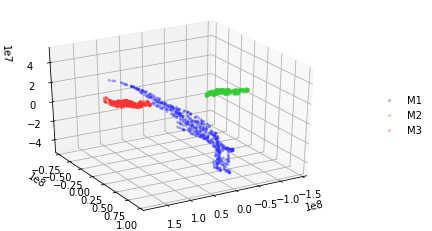

In [45]:
drawThingsOnReducedDomain3D(pcaFeatures, labels, [], [], 'pca_empty_transparent.3D.png', [], [], [], [])

In [46]:
aug = ImageDataGenerator(fill_mode="nearest", , rescale=1/255.0)

augmentation = aug.flow_from_directory(imgDir,classes=[classes_all[0]], batch_size = TRAINING_SIZE_SMALL, target_size=IMAGE_SIZE,shuffle=True, seed=20, class_mode="sparse")
print(augmentation.class_indices)
for x, y in augmentation:
	data_300 = x
	labels_300 = y
	break
data_300 = preprocess_input(data_300)
features_300 = get_gram_batch(data_300)
pcaFeatures_300 = pca.transform(features_300)

centroid = np.mean(pcaFeatures_300, axis=0)


Found 20240 images belonging to 1 classes.
{'300.3': 0}


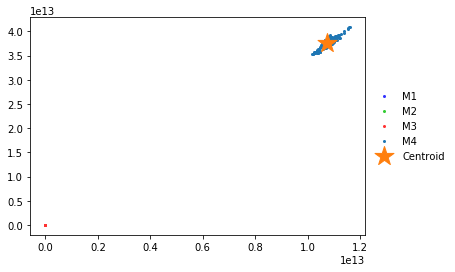

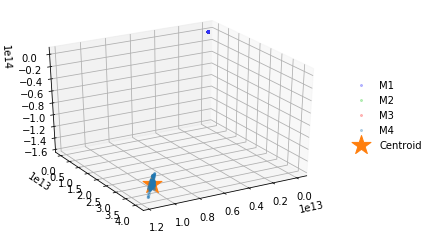

In [47]:
drawThingsOnReducedDomain(pcaFeatures, labels, [pcaFeatures_300, centroid[np.newaxis, :]], ['M4', 'Centroid'], 'pca_with300.3.png', [None, None], [4, 400], [None, '*'], [None, None])
drawThingsOnReducedDomain3D(pcaFeatures, labels, [pcaFeatures_300, centroid[np.newaxis, :]], ['M4', 'Centroid'], 'pca_with300.3D.png', [None, None], [4, 400], [None, '*'], [0.3, None])

Read new Al dataset and project those onto the reduced domain

Draw Al on Plot

In [50]:
def generateFromReducedDomain(features, pca, network=None):
    STYLE_WEIGHT = 1.0
    VAR_WEIGHT = 1.0
    gram_mat = pca.inverse_transform(features)
    generated = generateImageFromGramMatrix(gram_mat, H=IMAGE_SIZE[0], W=IMAGE_SIZE[1], C=3, S_weight=STYLE_WEIGHT, V_weight=VAR_WEIGHT, iters=20, vgg19=network)
    return generated

Start of iteration 0
Current loss value: 3369481800000000.0
Iteration 0 completed in 2s
Start of iteration 1
Current loss value: 3369481800000000.0
Iteration 1 completed in 1s
Start of iteration 2
Current loss value: 3369481800000000.0
Iteration 2 completed in 1s
Start of iteration 3
Current loss value: 3369481800000000.0
Iteration 3 completed in 1s
Start of iteration 4
Current loss value: 3369481800000000.0
Iteration 4 completed in 1s
Start of iteration 5
Current loss value: 3369481800000000.0
Iteration 5 completed in 1s
Start of iteration 6
Current loss value: 3369481800000000.0
Iteration 6 completed in 1s
Start of iteration 7
Current loss value: 3369481800000000.0
Iteration 7 completed in 1s
Start of iteration 8
Current loss value: 3369481800000000.0
Iteration 8 completed in 1s
Start of iteration 9
Current loss value: 3369481800000000.0
Iteration 9 completed in 1s
Start of iteration 10
Current loss value: 3369481800000000.0
Iteration 10 completed in 1s
Start of iteration 11
Current 

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Current loss value: 3369481800000000.0
Iteration 19 completed in 1s


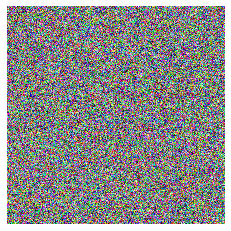

In [51]:
generatedM7 = generateFromReducedDomain(centroid, pca)
imsave('300.3_centroid_generated.png', generatedM7)

plt.figure()
plt.axis('off')
plt.imshow(generatedM7)
plt.show()

In [0]:
aug_Al = ImageDataGenerator(
		fill_mode="nearest")

augmentation_Al = aug_Al.flow_from_directory(TRAIN, classes=CLASSES_AL, batch_size = TRAINING_SIZE_SMALL, target_size=IMAGE_SIZE,shuffle=True, seed=20, class_mode="sparse")
print(augmentation_Al.class_indices)
for x, y in augmentation_Al:
	data_Al = x
	labels_Al = y
	break

features_Al = get_gram_batch(data_Al)
features_Al.shape

pcaFeatures_Al = pca.transform(features_Al)

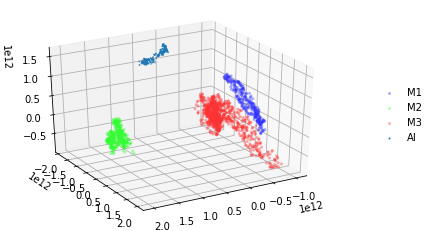

In [57]:
drawThingsOnReducedDomain3D(pcaFeatures, labels, [pcaFeatures_Al], ['Al'], 'pca_with_Al.png', [None, None], [4], ['.'], [None])

Put new image in the plot

Calculate the variance and the restore error and the centroid

In [52]:
M4 = pcaFeatures_300
restoredM4 = pca.inverse_transform(M4)
M4_orig = features_300

idx = np.where(labels == 0)
M1 = pcaFeatures[idx]
restoredM1 = pca.inverse_transform(M1)
M1_orig = features[idx]

restoredAl = pca.inverse_transform(pcaFeatures_Al)

valRestored = pca.inverse_transform(X_test)
valOrig = X_test_

from sklearn.metrics import mean_squared_error

zeros = np.zeros(M4_orig.shape)

errM4 = mean_squared_error(M4_orig, restoredM4) / mean_squared_error(M4_orig, zeros)
errAl = mean_squared_error(features_Al, restoredAl) / mean_squared_error(features_Al, zeros)


print(errM4, errAl)
print(1-errM4, 1-errAl)
# from sklearn.metrics import explained_variance_score

# expM1 = explained_variance_score(M1_orig, restoredM1)
# expM4 = explained_variance_score(M4_orig, restoredM4)
# expAl = explained_variance_score(features_Al, restoredAl)
# expVal = explained_variance_score(valOrig, valRestored)
# print(expM1, expM4, expAl, expVal)

# print(mse)
# print(mse / np.sum(M4_orig**2))

# print(mseAl)
# print(mseAl / np.sum(features_Al**2))
# print(np.mean(pcaFeatures_Al, axis=0))


NameError: name 'pcaFeatures_Al' is not defined

In [39]:
expVar = np.sum(pca.explained_variance_)
origVar = np.sum(np.var(features_300, axis=0))
print(expVar)
origVar

1.6815863e+24


9.32401e+22

In [35]:
def projectImage(newImg, pca, pcaFeatures):

    newFeatures = get_gram_batch(newImg[np.newaxis, :, :])
    newPCAFeatures = pca.transform(newFeatures)
    return newPCAFeatures
    # fig = plt.figure()
    # fig.add_subplot()

    # counter = 1
    # for i in range(3):
    #     idx = np.where(labels == i)
    #     plt.scatter(pcaFeatures[idx, 0], pcaFeatures[idx, 1], s=4)

    # plt.scatter(newPCAFeatures[0, 0], newPCAFeatures[0, 1], s=400, marker='x')
    # plt.legend([*classes, 'New Data'], loc='lower right')
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.show()

Generate new sample from image 600.3 (label=2)

In [56]:
idx = np.random.choice(np.where(labels == 1)[0], 1)
styleImg = data[idx]
CONTENT_WEIGHT = 0
TOTAL_VARIATION_WEIGHT = 0.001
STYLE_WEIGHT = 1.0

generated = generateImageFromStyle(H=IMAGE_SIZE[0], W=IMAGE_SIZE[1], C=3, S_weight=STYLE_WEIGHT, V_weight=TOTAL_VARIATION_WEIGHT, style_image=styleImg, iters=20)

Start of iteration 0
Current loss value: 349.36868
Iteration 0 completed in 4s
Start of iteration 1
Current loss value: 174.89061
Iteration 1 completed in 3s
Start of iteration 2
Current loss value: 144.56625
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 125.167015
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 112.79431
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 104.38718
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 97.99632
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 93.29265
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 89.56533
Iteration 8 completed in 3s
Start of iteration 9
Current loss value: 86.449036
Iteration 9 completed in 3s
Start of iteration 10
Current loss value: 83.60455
Iteration 10 completed in 3s
Start of iteration 11
Current loss value: 81.28665
Iteration 11 completed in 3s
Start of iteration 12
Current loss value: 79.015526


Show the generated image and project it to the reduced domain

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Lossy conversion from float64 to uint8. Range [-0.24467276949888195, 0.8475279216277335]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\AngelofDeath\.conda\envs\thesis\lib\site-packages\ipykernel_launcher.py:10: UserWarning: style.png is a low contrast image
  # Remove the CWD from sys.path while we load stuff.


NameError: name 'projectImage' is not defined

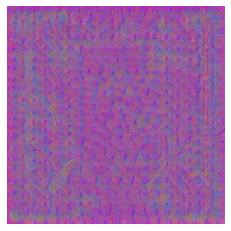

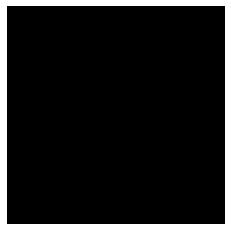

In [57]:
fig = plt.figure()
plt.axis('off')
plt.imshow(generated)

fig = plt.figure()
plt.axis('off')
plt.imshow(styleImg[0].astype(np.uint8))

imsave('generated.png', generated)
imsave('style.png', styleImg[0].astype(np.uint8))

projectImage(generated, pca, pcaFeatures)
projectImage(styleImg[0].astype(np.uint8), pca, pcaFeatures)

Try to figure out the validity of the generated image. 

In [73]:
def correcoeHist(imgA, imgB):
    histA_R = cv2.calcHist(imgA, [0],None, [256], [0,256])
    histA_G = cv2.calcHist(imgA, [1],None, [256], [0,256])
    histA_B = cv2.calcHist(imgA, [2],None, [256], [0,256])

    histB_R = cv2.calcHist(imgB, [0],None, [256], [0,256])
    histB_G = cv2.calcHist(imgB, [1],None, [256], [0,256])
    histB_B = cv2.calcHist(imgB, [2],None, [256], [0,256])
    
    histA = np.concatenate([histA_R, histA_G, histA_B], axis=0)
    histB = np.concatenate([histB_R, histB_G, histB_B], axis=0)
    # return cv2.compareHist(histA, histB, cv2.HISTCMP_CORREL)
    
    # histA = cv2.calcHist([imgA], [0, 1, 2], None, [256] * 3, [0,256] * 3)
    # histB = cv2.calcHist([imgB], [0, 1, 2], None, [256] * 3, [0,256] * 3)
    
    return [cv2.compareHist(histA_R, histB_R, cv2.HISTCMP_CORREL), cv2.compareHist(histA_G, histB_G, cv2.HISTCMP_CORREL), cv2.compareHist(histA_B, histB_B, cv2.HISTCMP_CORREL)]

In [133]:
correcoeHist(styleImg[0, :, :, :], generated.astype(np.float32))

[0.8065433140195019, 0.8542674048689335, 0.8906002487609911]

In [78]:
GENERATED_IMG = 'generated300.3_0VAR.png'
ORIGINAL_IMG = '600.3_.png'
img = imread(GENERATED_IMG)
img2 = imread(ORIGINAL_IMG)

# plt.hist(img[:, :, 0].ravel(),256,[0,256])
# plt.show()
# plt.hist(img[:, :, 1].ravel(),256,[0,256])
# plt.show()
# plt.hist(img[:, :, 2].ravel(),256,[0,256])
# plt.show()


In [79]:
# plt.hist(img2[:, :, 0].ravel(),256,[0,256])
# plt.show()
# plt.hist(img2[:, :, 1].ravel(),256,[0,256])
# plt.show()
# plt.hist(img2[:, :, 2].ravel(),256,[0,256])
# plt.show()

First figure: Projection of randomly generated image, 2nd figure: point image generated from

Try to generate in-between data

In [24]:
def generateInBetween(imgA, imgB, pca):
    STYLE_WEIGHT = 1.0
    VAR_WEIGHT = 5.0
    featuresAB_full = get_gram_batch(np.stack([imgA, imgB], axis=0))
    featuresAB = pca.transform(featuresAB_full)
    midpoint = np.sum(featuresAB, axis=0) / 2.0
    gram_mat_mid = pca.inverse_transform(midpoint)
    generated = generateImageFromGramMatrix(gram_mat_mid, H=IMAGE_SIZE[0], W=IMAGE_SIZE[1], C=3, S_weight=STYLE_WEIGHT, V_weight=VAR_WEIGHT, iters=20)
    return generated, midpoint

generate in-between sampels from 300.9, 600.9

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Start of iteration 0
Current loss value: 1033732800000.0
Iteration 0 completed in 2s
Start of iteration 1
Current loss value: 382222470000.0
Iteration 1 completed in 2s
Start of iteration 2
Current loss value: 81057370000.0
Iteration 2 completed in 2s
Start of iteration 3
Current loss value: 21122144000.0
Iteration 3 completed in 2s
Start of iteration 4
Current loss value: 9972137000.0
Iteration 4 completed in 2s
Start of iteration 5
Current loss value: 5884522500.0
Iteration 5 completed in 2s
Start of iteration 6
Current loss value: 4279363000.0
Iteration 6 completed in 2s
Start of iteration 7
Current loss value: 3505143300.0
Iteration 7 completed in 2s
Start of iteration 8
Current loss value: 3110743600.0
Iteration 8 completed in 2s
Start of iteration 9
Current loss value: 2815090200.0
Iteration 9 completed in 2s
Start of iteration 10
Current loss value: 2623294700.0
Iteration 10 completed i

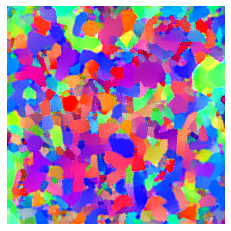

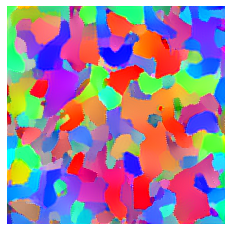

In [27]:
M7Point = centroid
"""
M5 = M2 and M3 
M6 = M1 and M3
"""
idxA = np.random.choice(np.where(labels == 1)[0], 1)
idxB = np.random.choice(np.where(labels == 2)[0], 1)
imgA = data[idxA]
imgB = data[idxB]
generatedM5, M5Point = generateInBetween(imgA[0, :, :, :], imgB[0, :, :, :], pca)

idxA = np.random.choice(np.where(labels == 0)[0], 1)
idxB = np.random.choice(np.where(labels == 2)[0], 1)
imgA = data[idxA]
imgB = data[idxB]
generatedM6, M6Point = generateInBetween(imgA[0, :, :, :], imgB[0, :, :, :], pca)

# for i in range(0, N_PC):
#     M5Point[i] = np.random.uniform(np.min(pcaFeatures[:, i]), np.max(pcaFeatures[:, i]))
# generatedM5 = generateFromReducedDomain(M5Point, pca)

# for i in range(0, N_PC):
#     M6Point[i] = np.random.uniform(np.min(pcaFeatures[:, i]), np.max(pcaFeatures[:, i]))
# generatedM6 = generateFromReducedDomain(M6Point, pca)


imsave('in-between_predictM5.png', generatedM5)
imsave('in-between_predictM6.png', generatedM6)

fig = plt.figure()
plt.axis('off')
plt.imshow(generatedM5)
plt.show()

fig = plt.figure()
plt.axis('off')
plt.imshow(generatedM6)
plt.show()

In [29]:

M7Point = centroid
locFile = open('locations.txt', 'w')
locFile.write( "300.3 Centroid: \n" + str(M7Point) + "\n")
locFile.write( "M5 Pt: \n" + str(M5Point) + "\n")
locFile.write( "M6 Pt: \n" + str(M6Point) + "\n")

centroids = []
for i in range(3):
    idx = np.where(labels == i)
    centroids.append(np.mean(pcaFeatures[idx[0], :], axis=0))

locFile.write( "M1-M3 centroids: \n" + str(centroids) + "\n")
locFile.close()


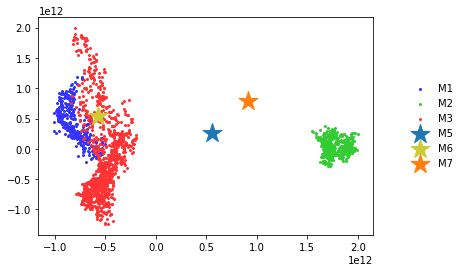

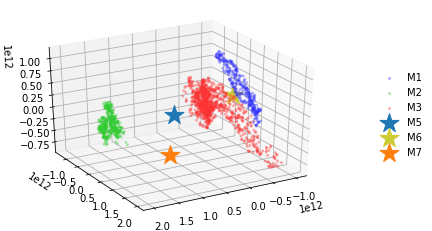

In [65]:

# M5Point = projectImage(generatedM5.astype(np.float32), pca, pcaFeatures)
# M6Point = projectImage(generatedM6.astype(np.float32), pca, pcaFeatures)
# M7Point = projectImage(generatedM7.astype(np.float32), pca, pcaFeatures)

drawThingsOnReducedDomain(pcaFeatures, labels, [M5Point[np.newaxis, :], M6Point[np.newaxis, :], M7Point[np.newaxis, :]], ['M5', 'M6', 'M7'], 'random_and_300.3_generation_projection.png', [None,  [(0.8, 0.8, 0.2)], None], [400, 400, 400], ['*', '*', '*'], [None, None, None, ])
drawThingsOnReducedDomain3D(pcaFeatures, labels, [M5Point[np.newaxis, :], M6Point[np.newaxis, :], M7Point[np.newaxis, :]], ['M5', 'M6', 'M7'], 'random_and_300.3_generation_projection3D.png', [None, [(0.8, 0.8, 0.2)], None], [400, 400, 400], ['*', '*', '*'], [None, None, None, ])


# plt.figure()
# for i in range(3):
#     idx = np.where(labels == i)
#     plt.scatter(pcaFeatures[idx, 0], pcaFeatures[idx, 1], s=4)

# plt.scatter(rand_point[0], rand_point[1], s=400, marker='x')

In [28]:
idxA = np.random.choice(np.where(labels == 0)[0], 1)
idxB = np.random.choice(np.where(labels == 2)[0], 1)
imgA = data[idxA]
imgB = data[idxB]
generated = generateInBetween(imgA[0, :, :, :], imgB[0, :, :, :], pca)


Start of iteration 0
Current loss value: 904067100000.0
Iteration 0 completed in 2s
Start of iteration 1
Current loss value: 279814500000.0
Iteration 1 completed in 2s
Start of iteration 2
Current loss value: 74433760000.0
Iteration 2 completed in 2s
Start of iteration 3
Current loss value: 20692738000.0
Iteration 3 completed in 2s
Start of iteration 4
Current loss value: 10197761000.0
Iteration 4 completed in 2s
Start of iteration 5
Current loss value: 5207068000.0
Iteration 5 completed in 2s
Start of iteration 6
Current loss value: 3735767000.0
Iteration 6 completed in 2s
Start of iteration 7
Current loss value: 2752155600.0
Iteration 7 completed in 2s
Start of iteration 8
Current loss value: 2289591300.0
Iteration 8 completed in 2s
Start of iteration 9
Current loss value: 2000325900.0
Iteration 9 completed in 2s
Start of iteration 10
Current loss value: 1758729000.0
Iteration 10 completed in 2s
Start of iteration 11
Current loss value: 1623826200.0
Iteration 11 completed in 2s
Start

Show the in-between data in plot

In [0]:
"""
NOT USED ANYMORE
"""

fig = plt.figure()
plt.axis('off')
plt.imshow(generatedM5)
fig = plt.figure()
plt.axis('off')
plt.imshow(imgA[0, :, :, :].astype(np.uint8))
fig = plt.figure()
plt.axis('off')
plt.imshow(imgB[0, :, :, :].astype(np.uint8))

imsave('in-between.png', generated)
# projectImage(generated.astype(np.float32), pca, pcaFeatures)

Figure X: Put new data in the scatter plot

Project 2 images used to generate in-between data to the plot

In [0]:

projectImage(imgA[0, :, :, :], pca, pcaFeatures)
projectImage(imgB[0, :, :, :], pca, pcaFeatures)

In [18]:
def generateImageForEachPCs(startPoint, nSteps, stepSize, pca, network=None):
    generatedImages = []
    points = []
    
    for i in range(4):
        generatePoint = np.copy(startPoint)
        PCvalues = np.linspace(startPoint[i] - nSteps * stepSize[i], startPoint[i] + nSteps * stepSize[i], num = nSteps * 2 + 1)
        print(PCvalues)
        for val in np.nditer(PCvalues):
            generatePoint[i] = val
            #generatedImages.append(generateFromReducedDomain(generatePoint, pca, network))
            points.append(np.copy(generatePoint[np.newaxis, :]))
    return generatedImages, points

                

In [28]:
import gc
gc.collect()

2773

Starting point=centrorid of M3

In [68]:
idx = np.where(y_train == 2)
std = np.std(X_train[idx[0],:], axis=0)
mean = np.mean(X_train[idx[0],:], axis=0)
# idx = np.random.choice(np.where(y_train == 2)[0], 1)
startPoint = mean
stepSize = std
stepSize[0] *= 4
stepSize[1:] *= 2



# combination_image = K.placeholder((1,) + IMAGE_SIZE + (3,))
# input_tensor = K.concatenate([combination_image], axis=0)
input_tensor = ks.Input(IMAGE_SIZE + (3,))
vgg19 = VGG19(input_tensor=input_tensor, weights='imagenet',
                include_top=False, pooling='avg')

generatedImages, points = generateImageForEachPCs(startPoint, 2, stepSize, pca, vgg19)

[-1.52952259e+12 -1.03314643e+12 -5.36770281e+11 -4.03941294e+10
  4.55982023e+11]
[-2.93846250e+12 -1.54012874e+12 -1.41794968e+11  1.25653880e+12
  2.65487257e+12]
[-1.21070175e+12 -6.64073216e+11 -1.17444682e+11  4.29183853e+11
  9.75812387e+11]
[-1.23496887e+12 -6.29583350e+11 -2.41978266e+10  5.81187697e+11
  1.18657322e+12]


Save the generated images and the arrays

In [44]:
np.save('images.npy', generatedImages) # save
np.save('points.npy', points) # save

In [72]:
PC_DIR = 'pc_gen/'
counter = 0
for image in generatedImages:
    imsave( PC_DIR + str(counter) + '.png', image)
    counter+=1
locFile = open(PC_DIR + 'locations.txt', 'w')
locFile.write(str(points))
locFile.close()

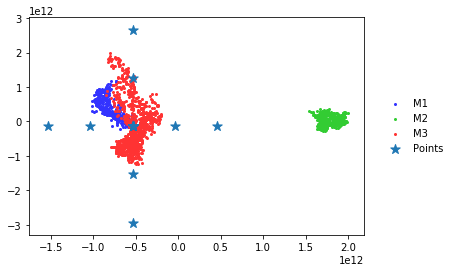

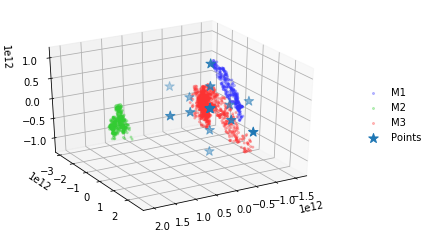

In [25]:
ptArray = np.concatenate(points)

drawThingsOnReducedDomain(pcaFeatures, labels, [ptArray], ['Points'], 'generateImageFromEachPC.png', [None], [100], ['*'], [None])
drawThingsOnReducedDomain3D(pcaFeatures, labels, [ptArray], ['Points'], 'generateImageFromEachPC.png', [None], [100], ['*'], [None])

In [77]:
K.clear_session()